<a href="https://colab.research.google.com/github/marabian/face-mask-detection/blob/master/face_mask_detection_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Mask Detection with CNNs
***

[Link to dataset](https://www.kaggle.com/wobotintelligence/face-mask-detection-dataset)

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import itertools
import shutil
import random
from random import randint
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [12]:
# check if tensorflow is identifying gpu, uncomment if using gpu
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#print("Num GPUs Available: " , len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [13]:
# check if gpu working on google colab
# tf.test.gpu_device_name()

In [14]:
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [3]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5



In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
# check gpu on colab
! nvidia-smi

Wed Dec 30 00:19:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 207...  On   | 00000000:01:00.0  On |                  N/A |
| 40%   26C    P8    11W / 215W |    817MiB /  7979MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
print(os.getcwd())

/home/mher/Desktop/face-mask-detection


In [6]:
# to mount google drive for colab
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [7]:
# colab command
%cd "/content/drive/My Drive/ml_projects/face-mask-detection"

/content/drive/My Drive/ml_projects/face-mask-detection


In [322]:
# git command used in colab
! git pull

remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 2 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (2/2), done.
From https://github.com/marabian/face-mask-detection
   3a9c716..a399b26  master     -> origin/master
Updating 3a9c716..a399b26
Fast-forward
 old_notebook.ipynb | 1500 ----------------------------------------------------
 1 file changed, 1500 deletions(-)
 delete mode 100644 old_notebook.ipynb


# Objective
***

Build and train a **Convolutional Neural Network** using Tensorflow's Keras API that can classify images of people by detecting face masks. The goal is to train a NN model that can take an image of a person, and identify if they are wearing a face-mask.

The model should classify images as either "mask" or "no-mask".

# Data Processing
***

First thing we need to do is to get and prepare out data set for which we will be training our model.
The data set we’ll use is from the Kaggle [Face Mask Detection Dataset](https://www.kaggle.com/wobotintelligence/face-mask-detection-dataset)

Download the dataset from Kaggle [here](https://www.kaggle.com/wobotintelligence/face-mask-detection-dataset). Our raw dataset contains 6,024 total images (in .png .jpg .jpeg formats) found under directory *data/medical_masks/images*. The first 1800 images are not labeled, and should be used for the **test set**. The remaining 4,224 can be used for **training** and **validation sets**. <br>
Lets take a look at the .csv file provided...

## Load csv data

In [7]:
# Let's see what our data looks like
df = pd.read_csv('data/train.csv')

In the dataframe below, each sample has a: 

- **name** - these are the names of the images in our dataset.
- **x1, x2, y1, y2** - [bounding box](https://medium.com/anolytics/the-use-of-bounding-boxes-in-image-annotation-for-object-detection-6371711eabba) coordinates
- **classname** - one of 20 possible classes: hijab_niqab, mask_colorful, mask_surgical, face_no_mask, face_with_mask_incorrect, face_with_mask, face_other_covering, scarf_bandana, balaclava_ski_mask, face_shield, other, gas_mask, turban, helmet, sunglasses, eyeglasses, hair_net, hat, goggles, hood. We will only consider the classes **face_with_mask** and **face_no_mask**.

We will use this data to construct new images using the script `split.py`

In [8]:
# Check out a few rows of the dataframe
print(df.shape)
df.head()

(15412, 6)


,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


## Preparing images for training

In this section, we will use helper scripts in the terminal to load the images and locate bounding boxes. To run these scripts, make sure you are using Tensorflow version 2.3.

1. Create train/valid directories. Split raw image data into subdirectories corresponding to their label (provided in *train.csv*).

    `python3 ml-image-processing-scripts/split.py -l face_with_mask face_no_mask -s 0.8 data/medical-mask/medical-mask/medical-mask/images/ data/train.csv`


2. Find bounding boxes for images, generate CSV file.

    `python3 ml-image-processing-scripts/bound_faces.py out/train/face_with_mask`

3. Crop images using bounding boxes to generate face images.

    `python3 ml-image-processing-scripts/crop.py -o face_with_mask out/train/face_with_mask faces.csv`

4. `mv face_with_mask train/`

Put *train/* and *test/* into *data* directory. Repeat these steps for `face_no_mask` class. To generate a seperate validation set, follow the same instructions.

To improve model performance, it can be useful to perform data cleaning: face images and remove obvious outliers (bad crop, not a face, etc) before training.

## Image processing using Keras

In [2]:
train_path = 'data/train'
valid_path = 'data/valid'
# test_path = 'data/test'

### Put images into [Keras Data Generator](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) format
[More on Data Generators](https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c)
This will basically create batches of data from the directories where our datasets reside. These batches of data will be able to be passed to the Sequential model using the **fit** function.

In [3]:
# Let's preprocess the images using Keras
train_batches = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['face_with_mask', 'face_no_mask'], batch_size=10)

valid_batches = ImageDataGenerator(rescale=1./255) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['face_with_mask', 'face_no_mask'], batch_size=10)

# shuffle=False because when we use our batches for inference, we want to look at the results in a confusion matrix
# so we need to access the unshuffled labels for our test set. 
# test_batches = ImageDataGenerator(rescale=1./255) \
    # .flow_from_directory(directory=test_path, target_size=(224,224), classes=['mask', 'no-mask'], batch_size=10, shuffle=False)

Found 1699 images belonging to 2 classes.
Found 413 images belonging to 2 classes.


In [4]:
# Using more data than just face_with_mask, face_no_mask labels (Google Colab)
assert train_batches.n == 4600 
assert valid_batches.n == 862 
assert test_batches.n == 287 
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes

AssertionError: 

In [ ]:
# Local training
assert train_batches.n == 1699
assert valid_batches.n == 413
assert train_batches.num_classes == valid_batches.num_classes

### Grab a single batch of images and corresponding labels from our training batches
Since our batch size is 10, this should be 10 images along with 10 corresponing labels. Lets print some of these images using this function pulled directly from [Tensorflow's website](https://www.tensorflow.org/tutorials/images/classification#visualize_training_images).

In [59]:
imgs, labels = next(train_batches)

In [60]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

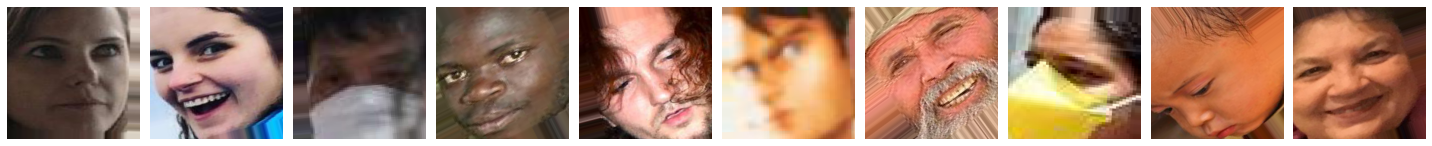

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [28]:
plotImages(imgs)
print(labels)

As seen above, the labels are [one-hot encoded](https://deeplizard.com/learn/video/v_4KWmkwmsU) vectors representing either 'mask' or 'no-mask'. A [1, 0] represents **mask**, and a [0, 1] represents **no-mask**.

# Build and Train a Convolutional Neural Network
***

## Lets create our CNN model! - first try

In [5]:
# first try
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=256, activation='relu'),
    Dropout(0.5),
    Dense(units=2, activation='softmax')
])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

In [7]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
history_m1 = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
170/170 - 16s - loss: 0.3908 - accuracy: 0.8423 - val_loss: 0.2393 - val_accuracy: 0.9128
Epoch 2/10
170/170 - 13s - loss: 0.2894 - accuracy: 0.9011 - val_loss: 0.2322 - val_accuracy: 0.9153
Epoch 3/10
170/170 - 13s - loss: 0.2609 - accuracy: 0.9082 - val_loss: 0.2280 - val_accuracy: 0.9153
Epoch 4/10
170/170 - 14s - loss: 0.2566 - accuracy: 0.9182 - val_loss: 0.2114 - val_accuracy: 0.9177
Epoch 5/10
170/170 - 13s - loss: 0.2462 - accuracy: 0.9258 - val_loss: 0.2085 - val_accuracy: 0.9177
Epoch 6/10
170/170 - 13s - loss: 0.2409 - accuracy: 0.9170 - val_loss: 0.2264 - val_accuracy: 0.9080
Epoch 7/10
170/170 - 13s - loss: 0.2338 - accuracy: 0.9223 - val_loss: 0.2335 - val_accuracy: 0.9031
Epoch 8/10
170/170 - 13s - loss: 0.2292 - accuracy: 0.9223 - val_loss: 0.2248 - val_accuracy: 0.9153
Epoch 9/10
170/170 - 13s - loss: 0.2295 - accuracy: 0.9247 - val_loss: 0.1989 - val_accuracy: 0.9322
Epoch 10/10
170/170 - 13s - loss: 0.2238 - accuracy: 0.9241 - val_loss: 0.2004 - val_accura

In [9]:
!mkdir -p saved_model
model.save('saved_model/first-try')

INFO:tensorflow:Assets written to: saved_model/first-try/assets


In [30]:
model.save_weights('models/first_try.h5')  # always save your weights after training or during training

In [10]:
# plot training metrics - learning curves
def plot_training_history(history):
    fig = plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

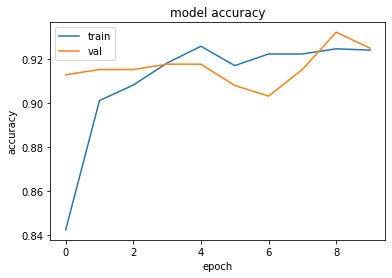

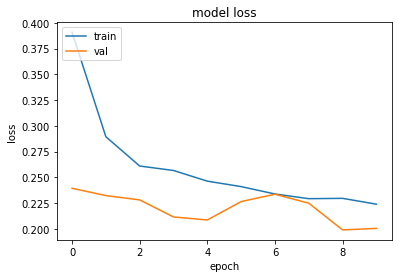

In [11]:
plot_training_history(history_m1)

**94% accuracy** on both training and validation sets, not bad! We can see that after epoch 4 the validation loss is steadily decreasing, maybe we can try training for more epochs.

## Let's try fine tuning vgg16 - second try

The only preprocessing applied to the images is the same preprocessing step used by the popular [vgg16](https://neurohive.io/en/popular-networks/vgg16/) image classifier CNN model.

In [23]:
# Let's preprocess the images in the same way vgg16 does
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, horizontal_flip=True) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['face_with_mask', 'face_no_mask'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['face_with_mask', 'face_no_mask'], batch_size=10)

# test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
#     .flow_from_directory(directory=test_path, target_size=(224,224), classes=['mask', 'no-mask'], batch_size=10, shuffle=False)

Found 1699 images belonging to 2 classes.
Found 413 images belonging to 2 classes.


In [24]:
# The original trained VGG16 model, along with its saved weights and other parameters
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(224, 224, 3))

In [25]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [26]:
# replicate to Sequential model and remove output layer
model_ft = Sequential()
# for layer in vgg16_model.layers[:-1]:
#     model_ft.add(layer)
for layer in vgg16_model.layers:
    model_ft.add(layer)

In [27]:
# freeze weights in all layers
for layer in model_ft.layers:
    layer.trainable = False

In [28]:
# add new output layer
model_ft.add(Flatten())
model_ft.add(Dense(units=256, activation="sigmoid")) # was 128
model_ft.add(Dropout(0.6)) # was 0.5
model_ft.add(Dense(units=2, activation='softmax'))

In [29]:
model_ft.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [30]:
#model_ft.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_ft.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.001, momentum=0.9), metrics=["accuracy"])

In [31]:
history_m2 = model_ft.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=15,
          verbose=2
)

Epoch 1/15
170/170 - 7s - loss: 0.4038 - accuracy: 0.8287 - val_loss: 0.2758 - val_accuracy: 0.9177
Epoch 2/15
170/170 - 6s - loss: 0.2630 - accuracy: 0.8964 - val_loss: 0.2566 - val_accuracy: 0.9031
Epoch 3/15
170/170 - 6s - loss: 0.2161 - accuracy: 0.9217 - val_loss: 0.2266 - val_accuracy: 0.9249
Epoch 4/15
170/170 - 6s - loss: 0.1987 - accuracy: 0.9288 - val_loss: 0.2111 - val_accuracy: 0.9249
Epoch 5/15
170/170 - 6s - loss: 0.1762 - accuracy: 0.9370 - val_loss: 0.2215 - val_accuracy: 0.9177
Epoch 6/15
170/170 - 6s - loss: 0.1568 - accuracy: 0.9447 - val_loss: 0.2000 - val_accuracy: 0.9298
Epoch 7/15
170/170 - 6s - loss: 0.1585 - accuracy: 0.9429 - val_loss: 0.2123 - val_accuracy: 0.9322
Epoch 8/15
170/170 - 7s - loss: 0.1501 - accuracy: 0.9506 - val_loss: 0.2099 - val_accuracy: 0.9274
Epoch 9/15
170/170 - 7s - loss: 0.1651 - accuracy: 0.9494 - val_loss: 0.2129 - val_accuracy: 0.9322
Epoch 10/15
170/170 - 7s - loss: 0.1374 - accuracy: 0.9553 - val_loss: 0.2020 - val_accuracy: 0.9370

**Note:** One reason why training loss might be higher than validation loss is because training loss is calculated throughout the training process, while validation loss is calculated at the end of each epoch. 

Also because of dropout, it is reasonable that the validation error is smaller than training error. Since usually dropout is activated when training but deactivated when evaluating on the validation set. You get a more smooth (usually means better) function in the latter case

In [35]:
model_ft.save('saved_model/second-try')

INFO:tensorflow:Assets written to: saved_model/second-try/assets


In [37]:
model_ft.save_weights('models/second_try.h5')  # always save your weights after training or during training

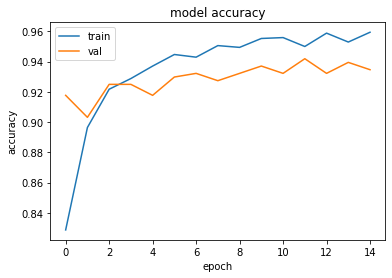

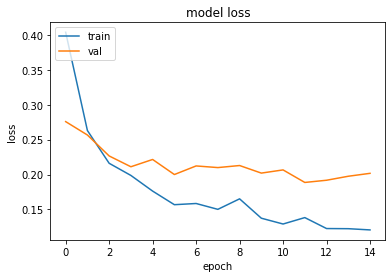

In [38]:
plot_training_history(history_m2) # plot learning curve

**96%** accuracy on training set, **97%** on validation set.

**Note:** We used SGD as our optimizer since we already have a model that is very good and don't want to change the weights too much. SGD is good choice for this as opposed to adaptive methods like Adam etc.

## Another fine-tuning approach - third try

Let's try the freeze, pre-train and finetune method:

First replace the last layer with a small mini network of 2 small Fully connected layers. Now, freeze all the pretrained layers and train the new network. Save the weights of this network (we did this in previous step).

Next load the pretrained weights and train the complete network with a smaller learning rate. This results in very good accuracy with even small datasets.

In [39]:
base_model = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(224, 224, 3))

In [40]:
# replicate to Sequential model and remove output layer
model_ft_1 = Sequential()
# for layer in vgg16_model.layers[:-1]:
#     model_ft.add(layer)
for layer in base_model.layers:
    model_ft_1.add(layer)

In [41]:
model_ft_1.add(Flatten())
model_ft_1.add(Dense(units=256, activation="sigmoid")) # was 128
model_ft_1.add(Dropout(0.5))
model_ft_1.add(Dense(units=2, activation='softmax'))

In [42]:
model_ft_1.load_weights("models/second_try.h5")

In [43]:
model_ft_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [44]:
model_ft_1.compile(loss="categorical_crossentropy", optimizer=SGD(lr=1e-05, momentum=0.9),metrics=["accuracy"])

In [45]:
history_m3 = model_ft_1.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=20,
          verbose=2
)

Epoch 1/20
170/170 - 19s - loss: 0.1016 - accuracy: 0.9670 - val_loss: 0.1970 - val_accuracy: 0.9346
Epoch 2/20
170/170 - 16s - loss: 0.0913 - accuracy: 0.9665 - val_loss: 0.1935 - val_accuracy: 0.9346
Epoch 3/20
170/170 - 16s - loss: 0.0894 - accuracy: 0.9653 - val_loss: 0.1913 - val_accuracy: 0.9370
Epoch 4/20
170/170 - 16s - loss: 0.0895 - accuracy: 0.9682 - val_loss: 0.1913 - val_accuracy: 0.9395
Epoch 5/20
170/170 - 16s - loss: 0.0832 - accuracy: 0.9717 - val_loss: 0.1917 - val_accuracy: 0.9322
Epoch 6/20
170/170 - 16s - loss: 0.0896 - accuracy: 0.9688 - val_loss: 0.1951 - val_accuracy: 0.9370
Epoch 7/20
170/170 - 16s - loss: 0.0809 - accuracy: 0.9741 - val_loss: 0.1930 - val_accuracy: 0.9370
Epoch 8/20
170/170 - 16s - loss: 0.0766 - accuracy: 0.9723 - val_loss: 0.1903 - val_accuracy: 0.9346
Epoch 9/20
170/170 - 16s - loss: 0.0816 - accuracy: 0.9729 - val_loss: 0.1955 - val_accuracy: 0.9395
Epoch 10/20
170/170 - 16s - loss: 0.0765 - accuracy: 0.9735 - val_loss: 0.1944 - val_accura

In [221]:
model_ft_1.save_weights('models/third_try.h5')

In [46]:
model_ft_1.save('saved_model/third-try')

INFO:tensorflow:Assets written to: saved_model/third-try/assets


**99%** accuracy on both training and validation sets!

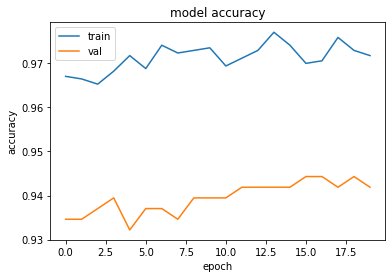

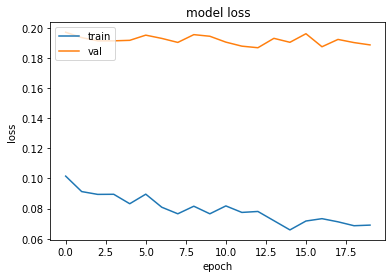

In [47]:
plot_training_history(history_m3) # plot learning curve

# Prediction using models
***

### Let's do inference using all 3 models

**First model**

In [52]:
# shuffle=False because when we use our batches for inference, we want to look at the results in a confusion matrix
# so we need to access the unshuffled labels for our test set. 
test_batches = ImageDataGenerator(rescale=1./255) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['mask', 'no-mask'], batch_size=10, shuffle=False)

NameError: name 'test_path' is not defined

In [50]:
new_model = tf.keras.models.load_model('saved_model/third-try')

In [223]:
model.load_weights('models/first_try.h5')

In [51]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

NameError: name 'test_batches' is not defined

In [231]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=2)

29/29 - 1s


In [232]:
predictions[0]

array([9.9999642e-01, 3.5681799e-06], dtype=float32)

**Second model**

In [250]:
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['mask', 'no-mask'], batch_size=10, shuffle=False)

Found 287 images belonging to 2 classes.


In [251]:
model_ft.load_weights('models/second_try.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

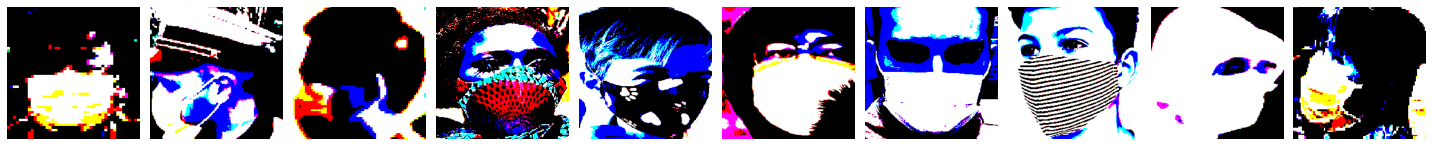

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [252]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [254]:
predictions_ft = model_ft.predict(x=test_batches, steps=len(test_batches), verbose=2)

29/29 - 2s


In [255]:
predictions_ft[2]

array([0.9624504 , 0.03754957], dtype=float32)

**Third model**

In [256]:
model_ft_1.load_weights('models/third_try.h5')
predictions_ft_1 = model_ft_1.predict(x=test_batches, steps=len(test_batches), verbose=2)

29/29 - 1s


In [257]:
predictions_ft_1[0]

array([9.997137e-01, 2.862110e-04], dtype=float32)

### Plot Predictions With A Confusion Matrix function using [scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

In [258]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[198  11]
 [  8  70]]


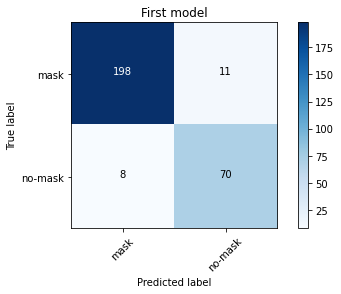

In [295]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['mask','no-mask']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='First model') # 93% accuracy on test set

We can see that the first model incorrectly predicted only 19 samples out of 287. This gives us 93% accuracy (1 - generalization error) on the test set, not bad!

Confusion matrix, without normalization
[[205   4]
 [  5  73]]


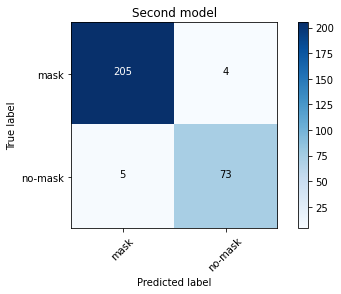

In [296]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions_ft, axis=-1))
cm_plot_labels = ['mask','no-mask']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Second model') # 97% accuracy on test set

Our second model (fine tuned) has 97% accuracy on test set.

Confusion matrix, without normalization
[[206   3]
 [  2  76]]


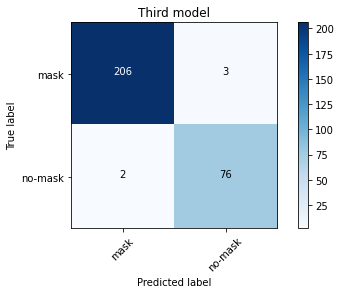

In [297]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions_ft_1, axis=-1))
cm_plot_labels = ['mask','no-mask']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Third model') # 98% accuracy on test set

Our third model obtained 98% accuracy on the same test set.

# Just for fun
***

Let's take some selfies and see if the model gets it right. I put two selfies under *data/me/*, one in *mask/*, the other in *no-mask/*.

In [53]:
# Use this if testing the fine tuned models.
# me_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, horizontal_flip=True) \
#     .flow_from_directory(directory='data/me', target_size=(224,224), classes=['mask', 'no-mask'], batch_size=10, shuffle=False)

me_batches = ImageDataGenerator(rescale=1./255) \
     .flow_from_directory(directory='data/me', target_size=(224,224), classes=['mask', 'no-mask'], batch_size=10, shuffle=False)

Found 2 images belonging to 2 classes.


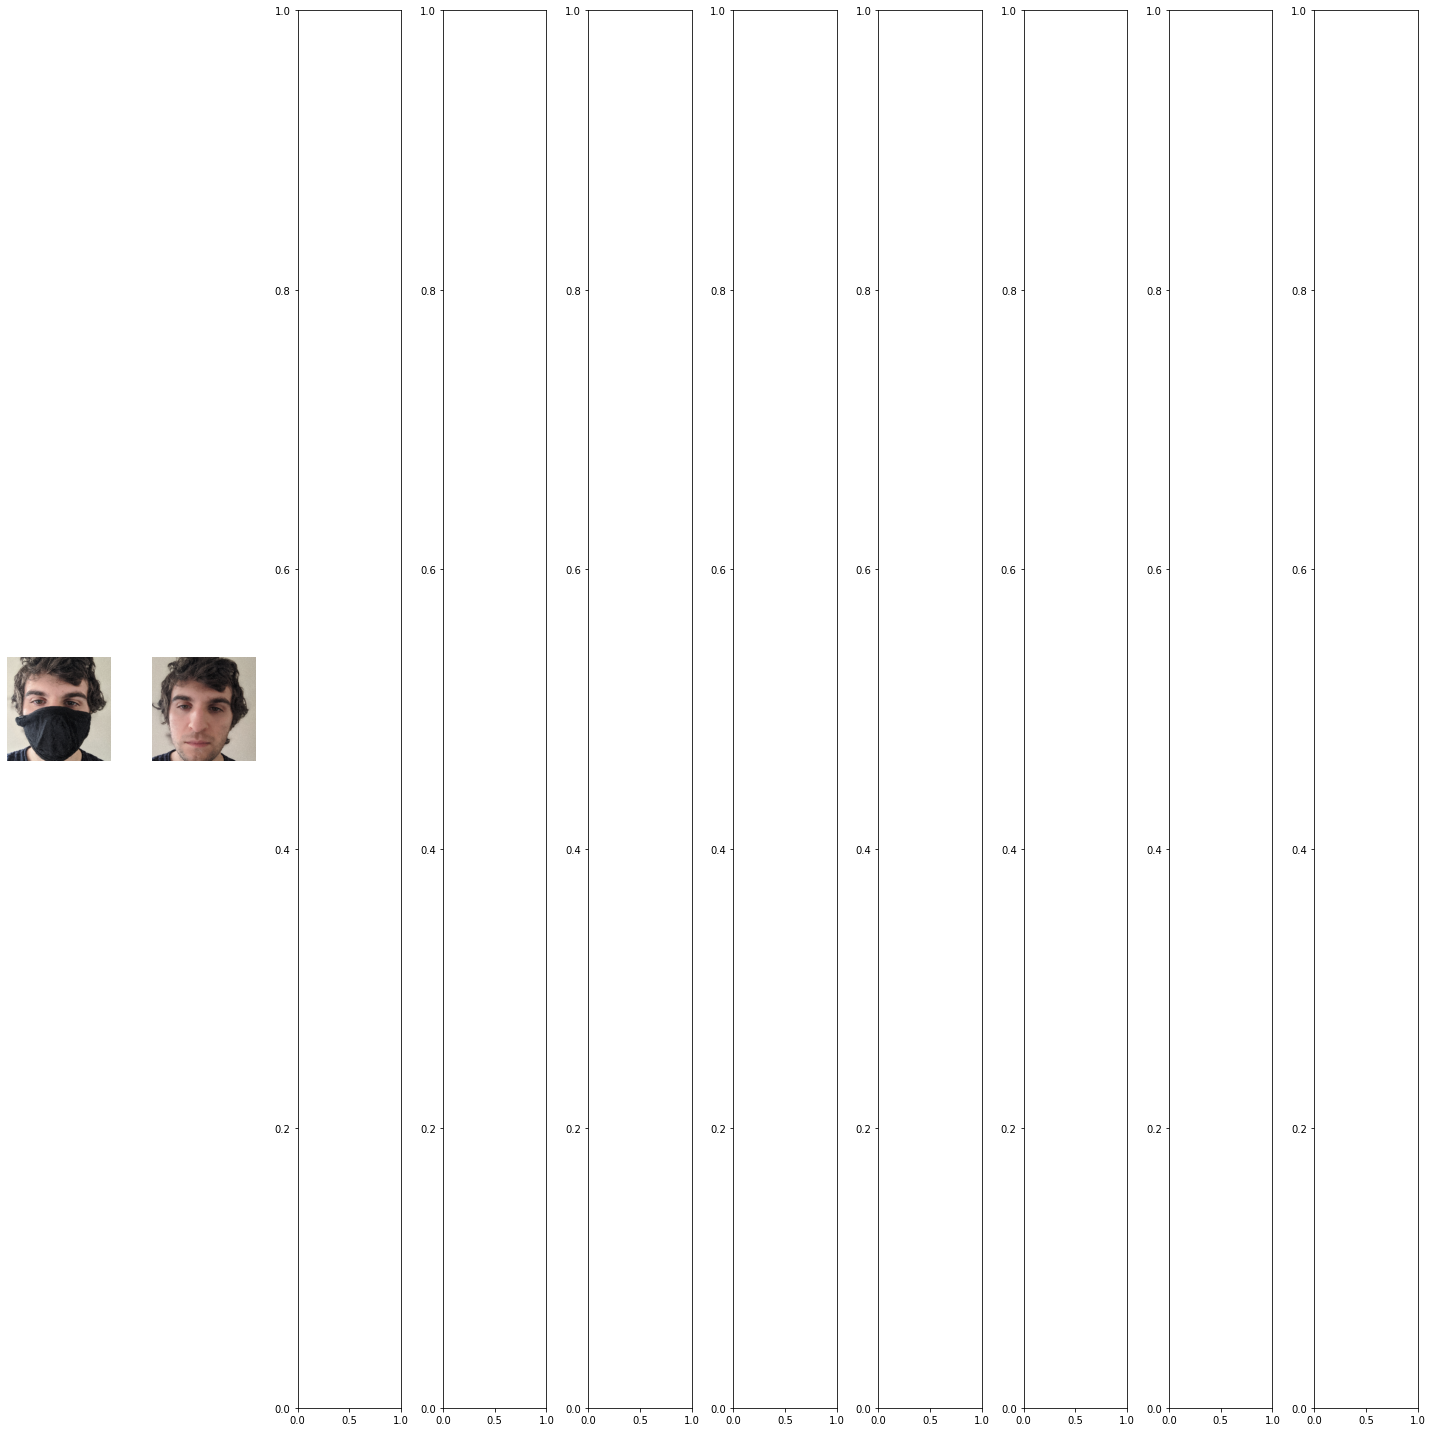

[[1. 0.]
 [0. 1.]]


In [61]:
me_imgs, me_labels = next(me_batches)
plotImages(me_imgs)
print(me_labels)

In [55]:
predictions_me = model.predict(x=me_batches, steps=len(me_batches), verbose=2)

1/1 - 0s


In [56]:
predictions_me

array([[0.8650533 , 0.13494664],
       [0.12004375, 0.87995625]], dtype=float32)

In [57]:
predictions_me = np.argmax(predictions_me, axis=-1)

In [58]:
print(predictions_me)

[0 1]


Got it right! **argmax** returns the position of the highest probability value in each predictiction vector [$p(mask), p(nomask)$] our model returns. So 0 means mask in the first selfie, 1 means no-mask in the second.

# Deployment
***

Multi-stage ML pipeline: 
1. Get the image (image upload, run script in terminal, etc)
2. Preprocess image
3. Locate bounding boxes using OpenCV
4. Make predictions for each bounding box
5. Based on predictions, draw red/green bounding boxes on original image
6. Display/save image

Ideas:
* Dockerize the pipeline
* Use AWS

First steps:
* Have a function to get image file from specified path, preprocess image and return tensor
* Have a function to get image file from specified path, predict mask/no-mask, return true/false.
* Have a function to get image file from specified path, predict bounding boxes, return array of bounding box coordinates.
* Have a function that takes in a list of bounding boxes, crops image into multiple images and saves on disk.
* Have a function that draws colored or grey bounding boxes on an image

In [2]:
print('ell')

ell


Load model